In [1]:
# Based on docs:
# https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html

# Also, see:
# https://github.com/giakoumoglou/classification/blob/main/notebooks/main_simclr.ipynb
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

## Imports

In [156]:
import os
from typing import Union
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils

## Configuration

We set some configuration parameters for our experiment.
Feel free to change them and analyze the effect.

The default configuration with a batch size of 256 and input resolution of 128
requires 6GB of GPU memory.



In [5]:
input_size = 32   # laptop
# input_size = 128  # PC
batch_size = 64   # laptop
# batch_size = 256  # PC

num_workers = 8
seed = 1
max_epochs = 10
num_ftrs = 32

Let's set the seed for our experiments



In [6]:
pl.seed_everything(seed)

Seed set to 1


1

In [7]:
# Create the directory if it doesn't exist
os.makedirs("./datasets/mnist", exist_ok=True)
os.makedirs("./datasets/mnist/train", exist_ok=True)
os.makedirs("./datasets/mnist/test", exist_ok=True)

In [8]:
# Download the MNIST dataset (if not already downloaded)
train_dataset = datasets.MNIST(root="./datasets/mnist", train=True, download=True)
test_dataset = datasets.MNIST(root="./datasets/mnist", train=False, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:33<00:00, 294976.28it/s]


Extracting ./datasets/mnist\MNIST\raw\train-images-idx3-ubyte.gz to ./datasets/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134388.85it/s]


Extracting ./datasets/mnist\MNIST\raw\train-labels-idx1-ubyte.gz to ./datasets/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 697356.21it/s]


Extracting ./datasets/mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets/mnist\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 445459.68it/s]

Extracting ./datasets/mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets/mnist\MNIST\raw



In [9]:
print(type(test_dataset.targets))
print(test_dataset.targets.shape)
print(test_dataset.targets[:10])
print(test_dataset.targets.unique(return_counts=True))

<class 'torch.Tensor'>
torch.Size([10000])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))


In [10]:
# Save the images to the directory
for i, (image, label) in enumerate(train_dataset):
    image.save(f"./datasets/mnist/train/{i}.png")

for i, (image, label) in enumerate(test_dataset):
    image.save(f"./datasets/mnist/test/{i}.png")

In [11]:
# Remove original data to prevent errors (if it exists)
# if os.path.exists("./datasets/mnist/MNIST"):
    # shutil.rmtree("./datasets/mnist/MNIST")

In [12]:
path_to_data = r"./datasets/mnist"
path_to_train_data = Path(path_to_data) / "train"
path_to_test_data = Path(path_to_data) / "test"

## Setup data augmentations and loaders

The images from the dataset have been taken from above when the clothing was
on a table, bed or floor. Therefore, we can make use of additional augmentations
such as vertical flip or random rotation (90 degrees).
By adding these augmentations we learn our model invariance regarding the
orientation of the clothing piece. E.g. we don't care if a shirt is upside down
but more about the strcture which make it a shirt.

You can learn more about the different augmentations and learned invariances
here: `lightly-advanced`.



In [13]:
transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,))  # Adjusted for single-channel images

        # torchvision.transforms.Normalize(
        #     mean=utils.IMAGENET_NORMALIZE["mean"],
        #     std=utils.IMAGENET_NORMALIZE["std"],
        # ),
    ]
)

In [14]:
test_dataset = datasets.MNIST(root="./datasets/mnist", train=False, download=True, transform=test_transform)

In [15]:
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [16]:
print(len(test_dataset))
print(test_dataset[0][1])
print(test_dataset[0][0].shape)

10000
7
torch.Size([1, 32, 32])


In [17]:
# dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)
train_dataset_simclr = LightlyDataset(input_dir=path_to_train_data, transform=transform)

# dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transform)
test_dataset_simclr = LightlyDataset(
    input_dir=path_to_test_data, transform=test_transform
)

In [18]:
print(len(train_dataset_simclr))
print(len(test_dataset_simclr))

60000
10000


In [19]:
dataloader_train_simclr = torch.utils.data.DataLoader(
    train_dataset_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test_simclr = torch.utils.data.DataLoader(
    test_dataset_simclr,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [20]:
for batch in dataloader_train_simclr:
    # batch_size = 256

    # as per docs (sample, target, fname)
    print("general")
    print(type(batch))
    print(len(batch))
    print()

    print("sample")
    print(type(batch[0]))
    print(len(batch[0]))
    print()

    print("sample[0]")
    print(type(batch[0][0]))
    print(len(batch[0][0]))
    print()

    print("sample[1]")
    print(type(batch[0][0]))
    print(len(batch[0][0]))
    print()

    print("target")
    print(type(batch[1]))
    print(batch[1].shape)
    print()

    print("target[0]")
    print(type(batch[1][0]))
    print(batch[1][0].shape)
    print(batch[1][0])
    print()

    print("target[1]")
    print(type(batch[1][1]))
    print(batch[1][1].shape)
    print()

    print("fname")
    print(type(batch[2]))
    print(len(batch[2]))
    print()

    print("fname[0]")
    print(type(batch[2][0]))
    print(batch[2][0])
    print()

    break

general
<class 'list'>
3

sample
<class 'list'>
2

sample[0]
<class 'torch.Tensor'>
64

sample[1]
<class 'torch.Tensor'>
64

target
<class 'torch.Tensor'>
torch.Size([64])

target[0]
<class 'torch.Tensor'>
torch.Size([])
tensor(0)

target[1]
<class 'torch.Tensor'>
torch.Size([])

fname
<class 'tuple'>
64

fname[0]
<class 'str'>
32401.png



## Create the SimCLR Model
Now we create the SimCLR model. We implement it as a PyTorch Lightning Module
and use a ResNet-18 backbone from Torchvision. Lightly provides implementations
of the SimCLR projection head and loss function in the `SimCLRProjectionHead`
and `NTXentLoss` classes. We can simply import them and combine the building
blocks in the module.



In [21]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

Train the module using the PyTorch Lightning Trainer on a single GPU.



In [21]:
# Uncomment for training (may take some time)

# model = SimCLRModel()
# trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="gpu")
# trainer.fit(model, dataloader_train_simclr)

Next we create a helper function to generate embeddings
from our test images using the model we just trained.
Note that only the backbone is needed to generate embeddings,
the projection head is only required for the training.
Make sure to put the model into eval mode for this part!



In [22]:
def generate_embeddings_simclr(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings.to("cpu"))
    return embeddings, filenames

In [23]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with the given model."""
    model.eval()  # Set the model to evaluation mode
    embeddings = []
    filenames = []

    with torch.no_grad():
        for img, _ in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings.cpu())
    return embeddings, filenames

In [24]:
# For eval only

# PC-trained model
# model = SimCLRModel.load_from_checkpoint(
#     "./lightning_logs/version_8/checkpoints/epoch=9-step=2340.ckpt"
# )

# laptop-trained model
# maybe not-OK, as it was trained on 70k images (both train and test)
model = SimCLRModel.load_from_checkpoint(
    "./lightning_logs/version_0/checkpoints/epoch=9-step=10930.ckpt"
)

In [25]:
model.eval()

SimCLRModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [26]:
embeddings, filenames = generate_embeddings_simclr(model, dataloader_test_simclr)

In [27]:
# embeddings, filenames = generate_embeddings(model, dataloader_test)

## Visualize Clusters in Embedding Space
Let's look at the trained embedding how they're clustered in latent space.

In [46]:
kmeans = KMeans(n_clusters=10)

In [47]:
labels = kmeans.fit_predict(embeddings)

In [48]:
labels[0:20]

array([3, 3, 9, 1, 2, 9, 3, 6, 8, 5, 0, 7, 8, 9, 9, 0, 8, 0, 2, 1])

In [49]:
test_dataset.targets[0:20]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])

In [50]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [53]:
def get_distance_between_points_in_cluster(embeddings: np.ndarray = None, labels: np.ndarray = None) -> dict:
    """Calculates the mean distance between points in the same cluster."""

    distances = {}
    for label in np.unique(labels):
        mask = labels == label
        cluster_points = embeddings[mask]
        distance = cdist(cluster_points, cluster_points).mean()
        distances[str(label)] = distance

    return distances

In [54]:
get_distance_between_points_in_cluster(embeddings, labels)

{'0': 0.6636954951561524,
 '1': 0.6134370548439225,
 '2': 0.679747551585475,
 '3': 0.6367346164300126,
 '4': 0.3514504258814965,
 '5': 0.6840714126737507,
 '6': 0.6836206059561489,
 '7': 0.5886999741360308,
 '8': 0.3279921057336686,
 '9': 0.503307225379734}

In [55]:
def get_distances_between_centroids(
    embeddings: np.ndarray = None, n_clusters: int = 10
) -> np.ndarray:
    """Calculate the clusters and distances between their centroids.

    Args:
        embeddings (np.ndarray, optional): Input embeddings. Defaults to None.
        n_clusters (int, optional): Should be 10 for MNIST, but generally is data-dependent. Defaults to 10.

    Returns:
        np.ndarray: matrix of distances between centroids, with rank n_clusters x n_clusters
    """
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(embeddings)
    centroids = kmeans.cluster_centers_

    print(f"Cluster centroids dimensions: {centroids.shape}")
    print(f"Cluster centroids:\n {centroids}")
    print(f"Cluster sizes: {np.bincount(labels)}")

    distances = cdist(centroids, centroids)
    return distances

In [56]:
distances = get_distances_between_centroids(embeddings)

Cluster centroids dimensions: (10, 512)
Cluster centroids:
 [[0.05226195 0.01342833 0.01919339 ... 0.04316696 0.05316192 0.02751138]
 [0.04292021 0.01179557 0.01712653 ... 0.02088795 0.01874096 0.01014404]
 [0.00805952 0.00125101 0.00672347 ... 0.00797418 0.00171126 0.00144891]
 ...
 [0.01890037 0.00677151 0.02072874 ... 0.0679663  0.00833261 0.0207163 ]
 [0.09574055 0.01340934 0.01446519 ... 0.01530732 0.04975973 0.00082285]
 [0.05971989 0.021533   0.08825895 ... 0.01111916 0.02572642 0.00023065]]
Cluster sizes: [ 585  994 1067 1134 1126 1258  633  989 1337  877]


In [57]:
print(f"Distances shape: {distances.shape}")
print(f"Distances rank: {np.linalg.matrix_rank(distances)}")
print(f"Distancess:\n {distances}")

Distances shape: (10, 10)
Distances rank: 10
Distancess:
 [[0.         0.76317556 1.04487941 0.93428555 1.0582205  0.85341471
  0.7829884  0.82715699 0.69839714 0.75778551]
 [0.76317556 0.         0.67527254 0.67200552 1.07987728 0.7435029
  0.88662156 0.88131393 0.69380814 0.83335373]
 [1.04487941 0.67527254 0.         0.82890341 0.90518723 0.84281182
  1.02388628 0.8032688  0.82429977 1.06627601]
 [0.93428555 0.67200552 0.82890341 0.         1.03360446 0.51116455
  0.80138972 0.98345918 0.96791314 0.80400528]
 [1.0582205  1.07987728 0.90518723 1.03360446 0.         1.0182229
  0.98532707 0.92748042 1.01457902 1.05209253]
 [0.85341471 0.7435029  0.84281182 0.51116455 1.0182229  0.
  0.92281278 0.76781625 0.8690753  0.7711936 ]
 [0.7829884  0.88662156 1.02388628 0.80138972 0.98532707 0.92281278
  0.         1.00221835 1.08138183 0.96040054]
 [0.82715699 0.88131393 0.8032688  0.98345918 0.92748042 0.76781625
  1.00221835 0.         0.80124562 1.04933811]
 [0.69839714 0.69380814 0.824299

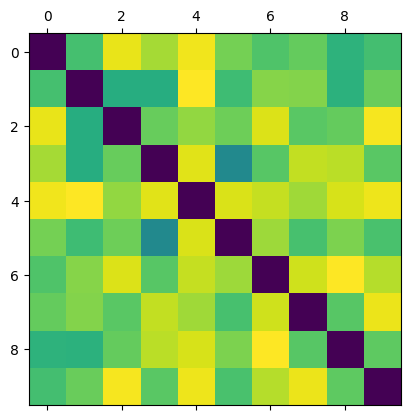

In [58]:
plt.matshow(distances, cmap="viridis")

In [59]:
visualization_df = pd.DataFrame(distances)
print(visualization_df)

          0         1         2         3         4         5         6  \
0  0.000000  0.763176  1.044879  0.934286  1.058220  0.853415  0.782988   
1  0.763176  0.000000  0.675273  0.672006  1.079877  0.743503  0.886622   
2  1.044879  0.675273  0.000000  0.828903  0.905187  0.842812  1.023886   
3  0.934286  0.672006  0.828903  0.000000  1.033604  0.511165  0.801390   
4  1.058220  1.079877  0.905187  1.033604  0.000000  1.018223  0.985327   
5  0.853415  0.743503  0.842812  0.511165  1.018223  0.000000  0.922813   
6  0.782988  0.886622  1.023886  0.801390  0.985327  0.922813  0.000000   
7  0.827157  0.881314  0.803269  0.983459  0.927480  0.767816  1.002218   
8  0.698397  0.693808  0.824300  0.967913  1.014579  0.869075  1.081382   
9  0.757786  0.833354  1.066276  0.804005  1.052093  0.771194  0.960401   

          7         8         9  
0  0.827157  0.698397  0.757786  
1  0.881314  0.693808  0.833354  
2  0.803269  0.824300  1.066276  
3  0.983459  0.967913  0.804005  
4  0

## Visualize Nearest Neighbors
Let's look at the trained embedding and visualize the nearest neighbors for
a few random samples.

We create some helper functions to simplify the work



In [60]:
def get_image_as_np_array(filename: str) -> np.ndarray:
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)

In [61]:
def plot_knn_examples(
    embeddings: np.ndarray = None,
    filenames: list = None,
    n_neighbors: int = 3,
    num_examples: int = 6,
    base_path: str = None,
) -> None:
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get num_examples random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    print(f"Samples index: {samples_idx}")
    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()

        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            fname = os.path.join(base_path, filenames[neighbor_idx])
            plt.imshow(get_image_as_np_array(fname))
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            plt.axis("off")

Samples index: [ 685 5338 6859 9153 1718 2563 2524 8429 7167 3544]


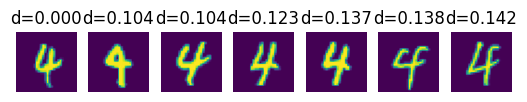

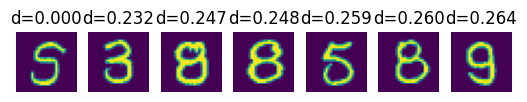

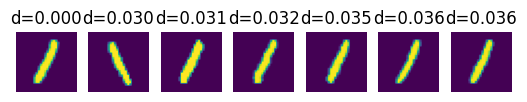

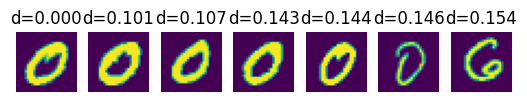

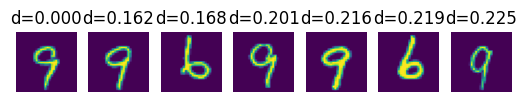

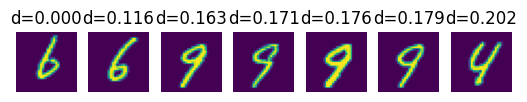

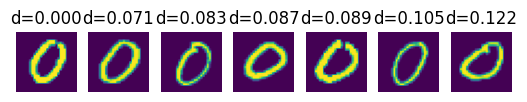

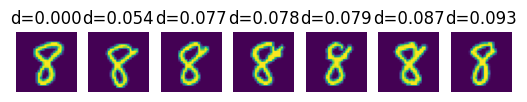

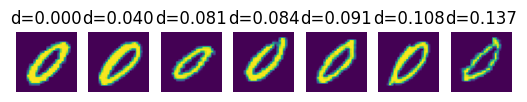

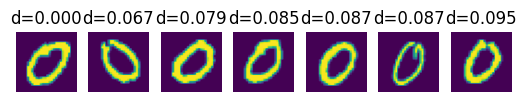

In [62]:
plot_knn_examples(
    embeddings, filenames, n_neighbors=7, num_examples=10, base_path=path_to_test_data
)

## Visualize Nearest Neighbours on 2D Plane
Let's look at the trained embedding, perform KNN, then PCA and visualize clusters in 2D space.

In [63]:
def plot_knn_clusters(
    embeddings: np.ndarray = None,
    original_labels: np.ndarray = None,
    n_neighbors: int = 5,
    num_examples: int = 10,
) -> None:
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = KNeighborsClassifier(n_neighbors=n_neighbors).fit(embeddings, original_labels)
    indices = nbrs.kneighbors(embeddings, return_distance=False)
    print(f"Indices shape: {indices.shape}")
    sampled_indices = np.random.choice(len(indices), num_examples, replace=False)
    print(f"Sampled indices: {sampled_indices}")
    
    for i in sampled_indices:
        print(f"Original label: {original_labels[i]}")
        print(f"Predicted label: {original_labels[indices[i]]}")

In [64]:
plot_knn_clusters(
    embeddings, np.array(test_dataset.targets), n_neighbors=5, num_examples=10
)

Indices shape: (10000, 5)
Sampled indices: [5295 8178 8030 3458 5848 4286  387 8848 7231 7772]
Original label: 5
Predicted label: [5 3 2 0 7]
Original label: 4
Predicted label: [4 1 2 0 6]
Original label: 7
Predicted label: [7 0 5 6 8]
Original label: 0
Predicted label: [0 2 8 8 9]
Original label: 1
Predicted label: [1 2 1 9 3]
Original label: 0
Predicted label: [0 6 1 5 3]
Original label: 2
Predicted label: [2 8 0 1 6]
Original label: 6
Predicted label: [6 6 7 5 1]
Original label: 0
Predicted label: [0 4 2 6 1]
Original label: 2
Predicted label: [2 7 9 8 3]


## Visualize Clusters on 2D Plane
Let's look at the trained embedding, perform PCA and visualize clusters in 2D space.

In [141]:
def plot_clusters(
    embeddings: Union[np.ndarray, None] = None,
    original_labels: Union[np.ndarray, None] = None,
    n_clusters: int = 10,
    proportion_of_points_to_plot: float = 0.001,
    alpha: float = 0.1,
    plot_centroids: bool = False,
    specific_labels: Union[list, None] = None
) -> None:
    """Plots multiple rows of random images with their cluster centroids"""

    print(f"Working on embeddings of shape {embeddings.shape}")
    
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(embeddings)
    centroids = kmeans.cluster_centers_

    # Filter points by specific_labels if provided
    if specific_labels is not None:
        mask = np.isin(original_labels, specific_labels)
        embeddings = embeddings[mask]
        original_labels = original_labels[mask]
        labels = labels[mask]
        print(f"Filtering to labels {specific_labels}: {embeddings.shape[0]} points left")

    # TODO: first cluster, then reduce to 2D
    # print(f"Cluster centroids:\n {centroids}")
    # print(f"Cluster sizes: {np.bincount(labels)}")

    # Sample proportion_of_points_to_plot of the data to plot for readability
    sampled_indices = np.random.choice(
        embeddings.shape[0],
        int(len(embeddings) * proportion_of_points_to_plot),
        replace=False,
    )

    sampled_embeddings = embeddings[sampled_indices]
    sampled_labels = original_labels[sampled_indices]
    sampled_cluster_labels = labels[sampled_indices]

    print(f"Plotting {len(sampled_embeddings)} points out of {len(embeddings)}")
    print(f"Some labels: {sampled_labels[:10]}")

    pca = PCA(n_components=2)
    to_plot_embeddings = pca.fit_transform(sampled_embeddings)
    to_plot_centroids = pca.transform(centroids)

    plt.scatter(
        to_plot_embeddings[:, 0],
        to_plot_embeddings[:, 1],
        c=sampled_labels,
        alpha=alpha,
        cmap="viridis",
    )
    
    # FIXME: plots suggest that the data is not clustered well
    if plot_centroids and specific_labels is not None:
        # Only plot centroids of clusters that have points with the specified labels
        unique_cluster_labels = np.unique(sampled_cluster_labels)
        for cluster_label in unique_cluster_labels:
            plt.scatter(to_plot_centroids[cluster_label, 0], to_plot_centroids[cluster_label, 1], c='red', marker='x')

    plt.colorbar(label="Original Class Labels")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(f"Cluster Plot {'for labels ' + str(specific_labels) if specific_labels is not None else ''}")
    plt.show()

In [142]:
# MNIST 'labels' created by simclr
print(type(test_dataset_simclr.dataset.targets))
unique_targets = np.unique(test_dataset_simclr.dataset.targets)
print(unique_targets)
print(test_dataset_simclr.dataset.targets[0])
print(type(test_dataset_simclr.dataset.targets[0]))

<class 'list'>
[0]
0
<class 'int'>


In [143]:
# original MNIST labels
print(type(test_dataset.targets))
unique_targets = np.unique(test_dataset.targets)
print(unique_targets)
print(test_dataset.targets[0])
print(type(test_dataset.targets[0]))

<class 'torch.Tensor'>
[0 1 2 3 4 5 6 7 8 9]
tensor(7)
<class 'torch.Tensor'>


Working on embeddings of shape (10000, 512)
Filtering to labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]: 10000 points left
Plotting 100 points out of 10000
Some labels: [0 4 1 0 3 4 1 4 3 8]


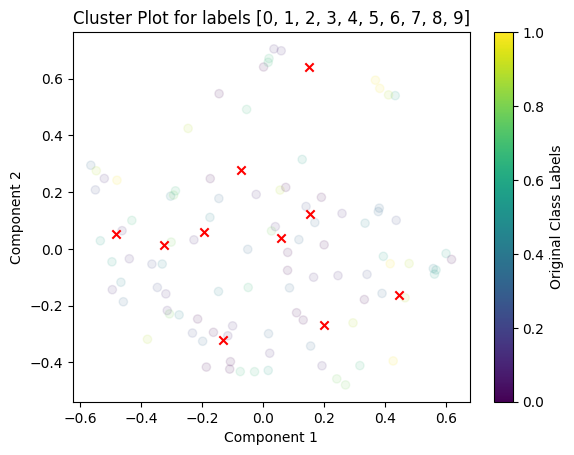

In [146]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.01,
    alpha=0.1,
    plot_centroids=True,
    specific_labels=list(range(10))
)

Working on embeddings of shape (10000, 512)
Filtering to labels [0, 1, 2, 3]: 4157 points left
Plotting 2078 points out of 4157
Some labels: [1 0 2 0 0 2 2 1 2 1]


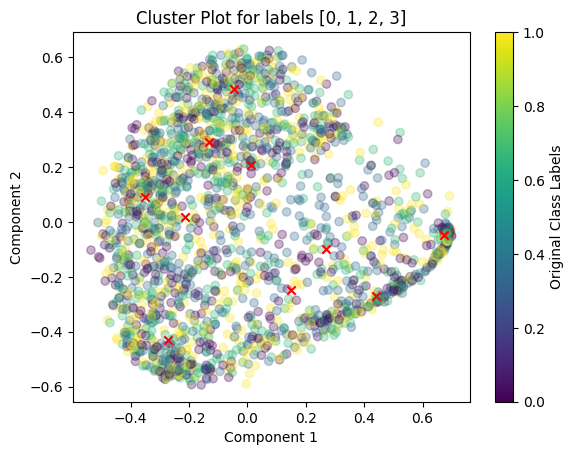

In [147]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.5,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[0, 1, 2, 3]
)

Working on embeddings of shape (10000, 512)
Filtering to labels [0, 8]: 1954 points left
Plotting 977 points out of 1954
Some labels: [8 8 0 0 8 8 8 8 0 0]


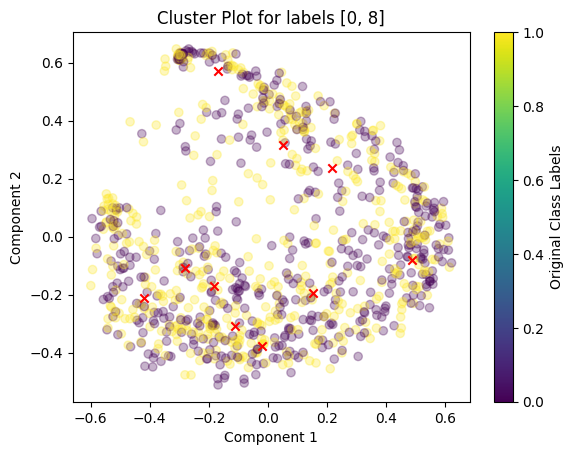

In [149]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.5,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[0, 8]
)

Working on embeddings of shape (10000, 512)
Filtering to labels [1, 4]: 2117 points left
Plotting 1058 points out of 2117
Some labels: [1 4 1 4 1 1 1 1 1 4]


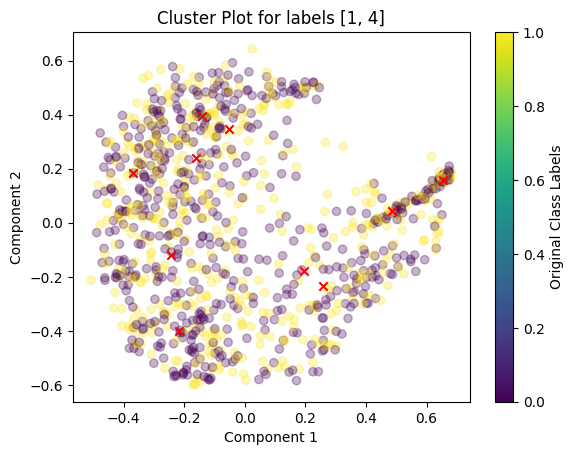

In [150]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.5,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[1, 4]
)

Working on embeddings of shape (10000, 512)
Filtering to labels [2, 3, 5, 8]: 3908 points left
Plotting 1954 points out of 3908
Some labels: [2 8 5 8 8 2 2 5 3 3]


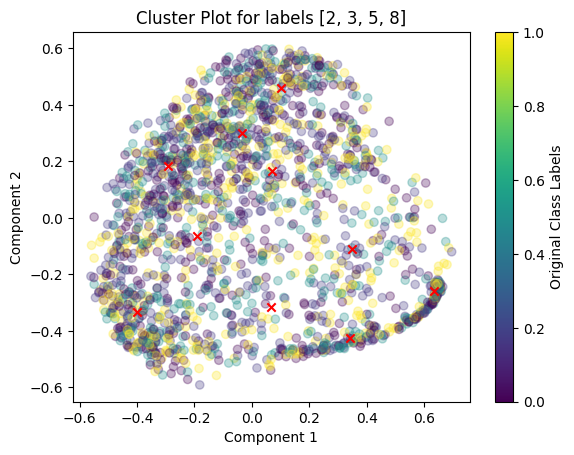

In [152]:
plot_clusters(
    embeddings,
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.5,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[2, 3, 5, 8]
)

## Check Labels Correspoding to Clusters
Let's check if the clusters in the embedding space correspond to the labels of the images.

In [73]:
def check_labels_correspondence(
    embeddings: np.ndarray = None, n_clusters: int = 10, num_examples: int = 7, base_path: str = None
) -> None:

    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(embeddings)
    unique_labels = set(labels)
    print(f"Unique labels: {unique_labels}")

    for label in unique_labels:
        # print(f"Label {label} has {np.sum(labels == label)} samples")
        label_indices = np.where(labels == label)[0]
        sampled_indices = np.random.choice(
            label_indices, size=num_examples, replace=False
        )
        # print(f"Length of sampled_indices: {len(sampled_indices)}")
        # print(f"Sampled indices: {sampled_indices}")

        fig = plt.figure()

        for subplot_idx, idx in enumerate(sampled_indices):
            ax = fig.add_subplot(len(unique_labels), num_examples, subplot_idx + 1)
            fname = os.path.join(base_path, filenames[idx])
            plt.imshow(get_image_as_np_array(fname))
            ax.set_title(f"Label {label}")
            plt.axis("off")

Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


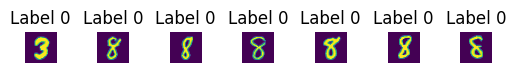

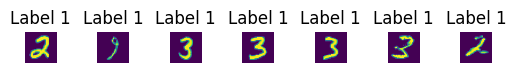

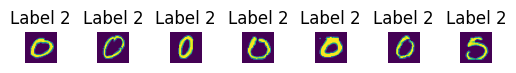

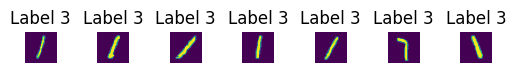

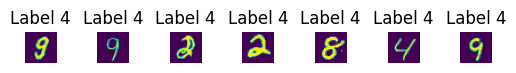

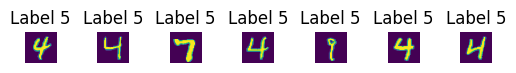

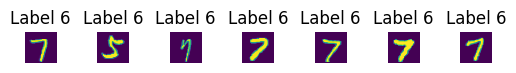

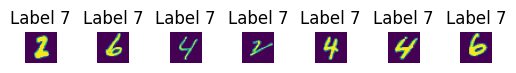

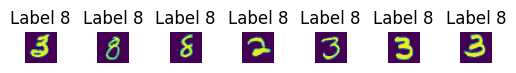

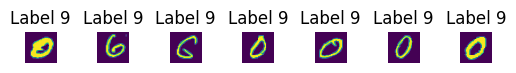

In [75]:
check_labels_correspondence(embeddings=embeddings, base_path=path_to_test_data)

## Simple clustering on MNIST
Let's check if it's possible to create good clusters from MNIST, working in pixel space.

In [79]:
test_dataset.targets[0:10]

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [81]:
len(test_dataset.test_data)

c:\Users\Maciek\__repos\ml_concepts\venv\Lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


10000

In [83]:
test_dataset.data[0].shape

torch.Size([28, 28])

In [85]:
mnist_clusters = KMeans(n_clusters=10).fit(test_dataset.data.reshape(-1, 28 * 28))

In [87]:
np.unique(mnist_clusters.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1442,  845,  531, 1270,  442,  981, 1462, 1009,  813, 1205],
       dtype=int64))

Working on embeddings of shape torch.Size([10000, 784])
Filtering to labels [0, 4, 7]: 2990 points left
Plotting 1196 points out of 2990
Some labels: [4 7 7 7 4 7 0 0 7 0]


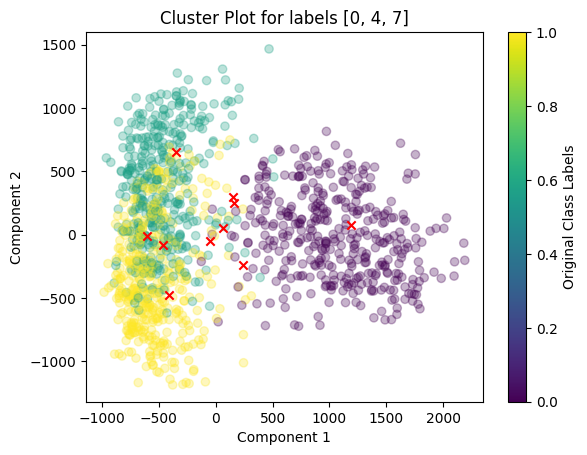

In [153]:
plot_clusters(
    test_dataset.data.reshape(-1, 28 * 28),
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.4,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[0, 4, 7]
)

Working on embeddings of shape torch.Size([10000, 784])
Filtering to labels [1, 4, 7]: 3145 points left
Plotting 1258 points out of 3145
Some labels: [1 1 1 7 1 7 1 4 4 1]


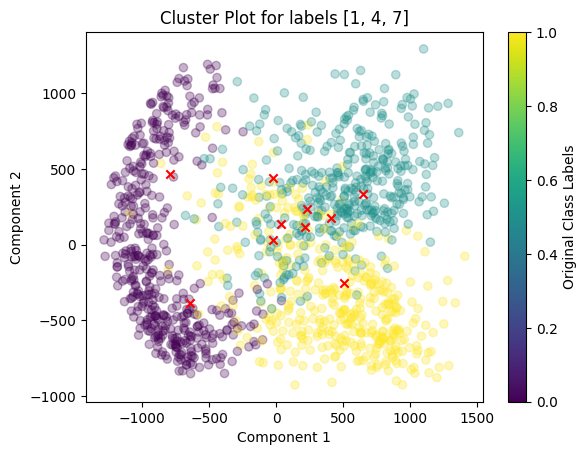

In [154]:
plot_clusters(
    test_dataset.data.reshape(-1, 28 * 28),
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.4,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[1, 4, 7]
)

Working on embeddings of shape torch.Size([10000, 784])
Filtering to labels [2, 3, 5, 8]: 3908 points left
Plotting 1563 points out of 3908
Some labels: [3 5 3 5 5 5 2 5 2 3]


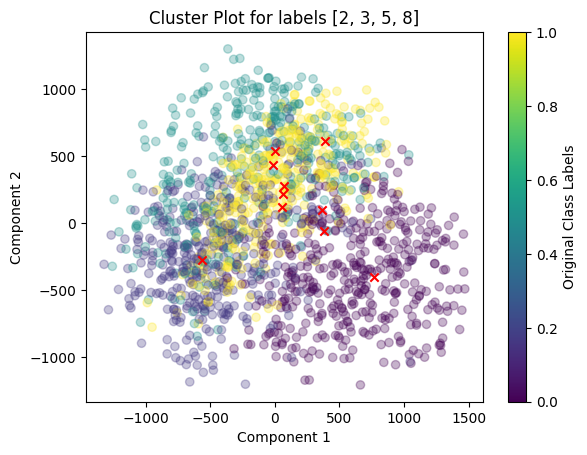

In [155]:
plot_clusters(
    test_dataset.data.reshape(-1, 28 * 28),
    np.array(test_dataset.targets),
    proportion_of_points_to_plot=0.4,
    alpha=0.3,
    plot_centroids=True,
    specific_labels=[2, 3, 5, 8]
)